# About the dataset
This dataset was downloaded from NEU Metal Surface Defects Databse which contains six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects.

But for this analysis, the dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.

I don't know for sure about the dataset sharing as it's not my own data that's why I kept it private.

In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
val_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir='/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
print("Path Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"))
print("Train Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train"))
print("Test Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid"))

Path Direcorty:  ['Thumbs.db', 'valid', 'test', 'train']
Train Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Test Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Validation Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']


## Here, you can see the dataset distribution for 'Inclusion' surface defect. Rest of the dataset also follow the same distribution

In [3]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


## Pre-processing the data

In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


## Stop training the model at 98% training accuracy

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

In [7]:
# Custom ResNet34 model
def custom_resnet34(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks (four groups with 3, 4, 6, and 3 convolutional layers)
    num_blocks_list = [3, 4, 6, 3]
    filters_list = [64, 128, 256, 512]
    for i in range(4):
        for j in range(num_blocks_list[i]):
            strides = 1 if i == 0 and j == 0 else 2
            x = residual_block(x, filters_list[i], strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name='custom_resnet34')

# Residual block
def residual_block(x, filters, strides):
    shortcut = x
    x = layers.Conv2D(filters, (1, 1), strides=strides)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters * 4, (1, 1))(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut connection dimensions if needed
    if strides != 1 or shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(filters * 4, (1, 1), strides=strides)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Create custom ResNet34 model
input_shape = (224, 224, 3)
num_classes = 6
model = custom_resnet34(input_shape, num_classes)

model.summary()

Model: "custom_resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
____________________________________________________________________________________

In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [9]:
# Train the model

callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
166/166 [==============================] - 29s 176ms/step - loss: 1.8818 - accuracy: 0.2923 - val_loss: 1.7925 - val_accuracy: 0.1667
Epoch 2/20
166/166 [==============================] - 22s 131ms/step - loss: 1.5392 - accuracy: 0.3551 - val_loss: 1.8180 - val_accuracy: 0.1667
Epoch 3/20
166/166 [==============================] - 23s 136ms/step - loss: 1.4783 - accuracy: 0.3732 - val_loss: 1.5879 - val_accuracy: 0.3194
Epoch 4/20
166/166 [==============================] - 22s 135ms/step - loss: 1.4706 - accuracy: 0.3889 - val_loss: 1.4386 - val_accuracy: 0.3472
Epoch 5/20
166/166 [==============================] - 21s 129ms/step - loss: 1.4257 - accuracy: 0.4088 - val_loss: 1.4180 - val_accuracy: 0.2500
Epoch 6/20
166/166 [==============================] - 22s 135ms/step - loss: 1.3615 - accuracy: 0.4408 - val_loss: 1.3279 - val_accuracy: 0.3611
Epoch 7/20
166/166 [==============================] - 23s 137ms/step - loss: 1.3278 - accuracy: 0.4601 - val_loss: 1.2845 - val_ac

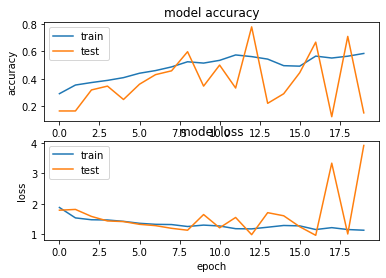

In [10]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()


In [13]:
# Evaluate on the test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Found 72 images belonging to 6 classes.
3/3 [==============================] - 0s 81ms/step - loss: 3.6324 - accuracy: 0.1111
Test accuracy: 11.11%


In [14]:
from sklearn.metrics import classification_report, confusion_matrix


In [17]:
# Evaluate on the test set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure predictions are in the same order as labels
)

# Get the predicted probabilities and labels for the test set
y_pred_probs = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = test_generator.classes

# Calculate metrics using scikit-learn functions
accuracy = np.mean(y_pred_labels == y_true_labels)
report = classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys())
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Print the metrics
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Found 72 images belonging to 6 classes.
Accuracy: 0.1111111111111111
Classification Report:
              precision    recall  f1-score   support

     Crazing       0.00      0.00      0.00        12
   Inclusion       0.00      0.00      0.00        12
     Patches       0.00      0.00      0.00        12
      Pitted       0.23      0.67      0.34        12
      Rolled       0.00      0.00      0.00        12
   Scratches       0.00      0.00      0.00        12

    accuracy                           0.11        72
   macro avg       0.04      0.11      0.06        72
weighted avg       0.04      0.11      0.06        72

Confusion Matrix:
[[ 0  0  3  9  0  0]
 [ 8  0  4  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  4  8  0  0]
 [ 0  0 10  2  0  0]
 [ 1  0  7  4  0  0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test Result visualization

In [ ]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
no_of_classes

In [ ]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)


In [ ]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

In [ ]:
x_test = x_test.astype('float32')/255

In [ ]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))